In [2]:
# https://towardsdatascience.com/decrypting-your-machine-learning-model-using-lime-5adc035109b5
import numpy as np
import lime
import lime.lime_tabular
from lime import lime_image
import sklearn.ensemble
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
# import time

In [3]:
# https://github.com/marcotcr/lime
# https://homes.cs.washington.edu/~marcotcr/blog/lime/
# https://arxiv.org/abs/1602.04938
# https://arxiv.org/pdf/2008.11092.pdf
# https://towardsdatascience.com/explainable-ai-xai-methods-part-5-global-surrogate-models-9c228d27e13a
# https://towardsdatascience.com/explainable-ai-xai-a-guide-to-7-packages-in-python-to-explain-your-models-932967f0634b
# https://github.com/oracle/Skater


In [4]:
def make_cmap(high_vals=False,low_vals=False):
	precip_clevs = [0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 70, 100, 150]
	if high_vals==True:
		# precip_clevs = [0, 20, 25, 30, 40, 50, 70, 100, 125, 150, 175,200, 225, 250, 300, 350, 400, 500]
		precip_clevs = [0, 20, 40, 60, 80, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 500]
	if low_vals == True:
		precip_clevs = [0, 2, 4, 6, 8, 10, 12, 14, 16, 19, 20, 22, 24, 26, 28, 30]
	# precip_cmap = matplotlib.colors.ListedColormap(metpy.plots.ctables.colortables["precipitation"][:len(precip_clevs)-1], 'precipitation')
	# precip_norm = matplotlib.colors.BoundaryNorm(precip_clevs, precip_cmap.N)

	tc_colours = [(255/255,255/255,255/255), # no rain
				(169/255, 209/255, 222/255), # drizzle 0-1
				(137/255, 190/255, 214/255), # drizzle 1-2
				(105/255, 160/255, 194/255), # drizzle 2-3
				(93/255, 168/255, 98/255), # drizzle 3-5
				(128/255, 189/255, 100/255), # very light rain 5-7
				(165/255, 196/255, 134/255), # light rain 7-10
				(233/255, 245/255, 105/255), # rain 10-15
				(245/255, 191/255, 105/255), # heavy rain 15-20
				(245/255, 112/255, 105/255), # heavier rain 20-25
				(245/255, 105/255, 149/255), # real heavy rain 25-30
				(240/255, 93/255, 154/255), # intense rain 30-40
				(194/255, 89/255, 188/255), # super intense rain 40-50
				(66/255, 57/255, 230/255), # insane amount of rain 50-70
				(24/255, 17/255, 153/255), # you do not want to be caught in this rain 70-100
				(9/255, 5/255, 87/255), # I can't belive the scle goes up this high 100-150
	]
	if high_vals == False:
		N = 16
	else:
		N=16
	precip_cmap = LinearSegmentedColormap.from_list('tc_colours',tc_colours,N=N) #increasing N makes it smoother
	precip_norm = matplotlib.colors.BoundaryNorm(precip_clevs, precip_cmap.N,extend='max')
	return precip_cmap,precip_norm

In [5]:
# 10 x 10 rain to 100 x 100 rain model - getting its original training input
feature_names_part2 = ['rain','mslp','q-925','u-200','u-850','v-200','v-850']
train_filepath_part2 = '/user/home/al18709/work/tc_data_flipped/train_combined_X.npy'
train_X_part2 = np.load(train_filepath_part2)
print(train_X_part2.shape)
train_part2 = train_X_part2[0,:,:,0]

# 10 x 10 rain to 100 x 100 rain model - making predictions from output of other model
input_filepath_part2 = '/user/home/al18709/work/gan_predictions_20/validation_pred-opt_scalar_test_run_3.npy'
critic_pred2 = np.load('/user/home/al18709/work/gan_predictions_20/validation_disc_pred-opt_modular_part2_raw.npy')[:,0,0]
gen_pred2 = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_modular_part2_raw.npy')
# critic_pred2_test = np.load('/user/home/al18709/work/gan_predictions_20/test_disc_pred-opt_modular_part2_raw.npy')[:,0,0]
input_part2 = np.load(input_filepath_part2)
print(input_part2.shape)
# train_part2 = train_X_part2[0,:,:,0]

# 1 x 6 model to 100 x 100 model
feature_names_part1 = ['mslp','u-850','v-850','wind_shear','centre_lat','centre_lon']
train_filepath_part1 = '/user/work/al18709/tc_data_flipped/KE_tracks/train_X.npy'
train_X_part1 = np.load(train_filepath_part1)
inputs_part1 = np.load('/user/work/al18709/tc_data_flipped/KE_tracks/valid_X.npy')
test_inputs_part1 = np.load('/user/work/al18709/tc_data_flipped/KE_tracks/test_X.npy')
pred_part1 = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_scalar_test_run_3.npy')[0,:,:,0]
real_part1 = np.load('/user/home/al18709/work/gan_predictions_20/validation_real-opt_scalar_test_run_3.npy')[0,:,:,0]
print(train_X_part1.shape)
train_part1 = train_X_part1[:,:]
print(pred_part1.shape)
print(real_part1.shape)
print(inputs_part1.shape)
print(critic_pred2.shape)

(45623, 10, 10, 7)
(15930, 10, 10, 20)
(45623, 6)
(10, 10)
(10, 10)
(15930, 6)
(15930,)


In [6]:
explainer = lime.lime_tabular.LimeTabularExplainer(train_part1, feature_names=feature_names_part1, mode='regression')
# do the critic maybe? Whats the difference between a good score and a bad score
# explainer = lime_image.LimeImageExplainer() 
# feed it images on decision boundary, one that defo a TC and one that's defo not
# it tells you how the features have contributed to wasserstein distance
# bLIMEy would do the decision tree model instead of the linear model, but might not be for images.
# bLIMEy probably does have surrogate image explainer
# will have to build model settings and implement lime in same script.
# use gradients to calculate the counterfactuals - so go to TC class and find the closest prediction to that sample that actually isn't a TC
# also use ensemble predictions for discriminator
# https://github.com/So-Cool/bLIMEy/blob/master/ECML-PKDD_2023/limetree_explanations.ipynb
# https://github.com/fat-forensics/events/blob/master/README.md
# https://events.fat-forensics.org
# saliance

In [7]:
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=1000)

In [8]:
rf.fit(inputs_part1, critic_pred2)

RandomForestRegressor(n_estimators=1000)

In [9]:
# print('Random Forest MSError', np.mean((rf.predict(test_inputs_part1) - labels_test) ** 2))

In [10]:
print(test_inputs_part1.shape)

(15705, 6)


In [11]:
min = critic_pred2.min()
[i] = np.where([critic_pred2 == min])[1]
print(i)
max = critic_pred2.max()
[j] = np.where([critic_pred2 == max])[1]

1439


In [12]:
# exp = explainer.explain_instance(test_inputs_part1[0,:], rf.predict, num_features=6)
# example with a low score (less realistic)
exp = explainer.explain_instance(inputs_part1[i,:], rf.predict, num_features=6) #look at fitting decision tree in fatf package - more meaingful splits and a decision tree

In [13]:
exp.show_in_notebook(show_table=True)

In [14]:
exp = explainer.explain_instance(inputs_part1[j,:], rf.predict, num_features=6)

In [15]:
# example with a high score (more realistic)
exp.show_in_notebook(show_table=True)

In [16]:
exp = explainer.explain_instance(inputs_part1[20,:], rf.predict, num_features=6)
exp.show_in_notebook(show_table=True)

In [ ]:
exp.as_list()

[('centre_lon <= -67.24', -0.6422954370319408),
 ('-11.96 < centre_lat <= 15.70', 0.6377293318194025),
 ('100760.10 < mslp <= 101026.11', -0.15586962750428715),
 ('-1.01 < v-850 <= 0.81', -0.08591328478090281),
 ('-4.39 < u-850 <= -2.07', -0.05073501149048882),
 ('wind_shear <= 2.12', 0.0024758147109660233)]

In [ ]:
print(gen_pred2.shape)


(15930, 100, 100, 20)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray # since the code wants color images
# from skimage.util.montage import montage2d 

In [ ]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()
# make each image color so lime_image works correctly
# define tcs
tcs = gen_pred2[:400,:,:,0]
# normalise to pretend it's grayscale?
tcs = tcs / tcs.max()
score_mean = critic_pred2.mean()
good_score = critic_pred2 >= score_mean

good_score = good_score[:400]
X_vec_face = np.stack([gray2rgb(iimg) for iimg in faces.data.reshape((-1, 64, 64))],0)
print(X_vec_face.shape)
y_vec_face = faces.target.astype(np.uint8)
X_vec = np.stack([gray2rgb(iimg) for iimg in tcs.reshape((-1, 100, 100))],0)
y_vec = good_score.astype(np.uint8)

print(X_vec.shape)

(400, 64, 64, 3)
(400, 100, 100, 3)


(-0.5, 99.5, 99.5, -0.5)

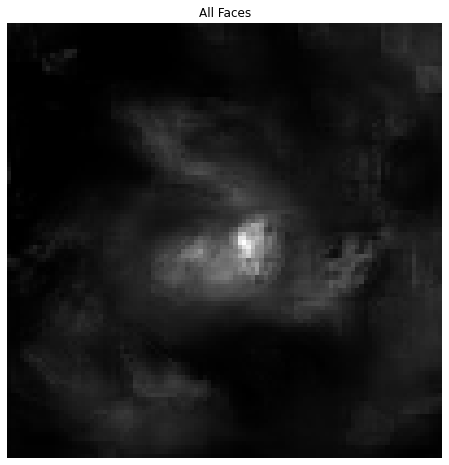

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize = (8,8))

ax1.imshow(X_vec[100,:,:,0], cmap='gray', interpolation = 'none')
ax1.set_title('All Faces')
ax1.axis('off')

In [ ]:
print(faces.data.shape)
print(faces.data.min())
print(faces.data.max())

(400, 4096)
0.0
1.0


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)

makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    ('Normalize', Normalizer()),
    ('PCA', PCA(25)),
    ('XGBoost', GradientBoostingClassifier())
                              ])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                    train_size=0.70)

In [ ]:
simple_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x7f479a382d10>),
                ('Flatten Image', <__main__.PipeStep object at 0x7f479a392a50>),
                ('Normalize', Normalizer()), ('PCA', PCA(n_components=25)),
                ('XGBoost', GradientBoostingClassifier())])

In [ ]:
# compute on remaining test data
pipe_pred_test = simple_rf_pipeline.predict(X_test)
pipe_pred_prop = simple_rf_pipeline.predict_proba(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, y_pred = pipe_pred_test))

              precision    recall  f1-score   support

           0       0.61      0.65      0.63        51
           1       0.73      0.70      0.71        69

    accuracy                           0.68       120
   macro avg       0.67      0.67      0.67       120
weighted avg       0.68      0.68      0.68       120



In [ ]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime

In [ ]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
# segmenter = SegmentationAlgorithm('slic', n_segments=200, compactness=1, sigma=1) # TODO: can change image segmentation algorithm and se what happens, to see contrast in quick changing values
# segmenter = SegmentationAlgorithm('watershed', n_segments=200, compactness=1, sigma=1) #Watersheds are transformations in a grayscale image. Watershed segmentation algorithms treat images like topographic maps, with pixel brightness determining elevation (height). This technique detects lines forming ridges and basins, marking the areas between the watershed lines. It divides images into multiple regions based on pixel height, grouping pixels with the same gray value.
segmenter = SegmentationAlgorithm('felzenszwalb', n_segments=400, compactness=1, sigma=1) # quickshift

In [ ]:
# X_vec 
storm = 100
explanation = explainer.explain_instance(X_vec[storm], 
                                         classifier_fn = simple_rf_pipeline.predict_proba, 
                                         top_labels=6, hide_color=0, num_samples=20000, segmentation_fn=segmenter)

# should really do explanation on test set but need to link with image of tc in correct colour scheme
# explanation = explainer.explain_instance(X_test[0], 
#                                          classifier_fn = simple_rf_pipeline.predict_proba, 
#                                          top_labels=6, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/20000 [00:00<?, ?it/s]

/user/work/al18709/.conda/envs/acidic/lib/python3.7/site-packages/skimage/color/colorlabel.py:129: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha, saturation)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Positive/Negative Regions for 0')

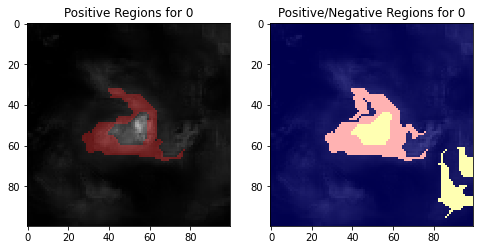

In [ ]:
from skimage.color import label2rgb
temp, mask = explanation.get_image_and_mask(y_test[storm], positive_only=True, num_features=5, hide_rest=False)
temp = temp*1/temp.max()
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[storm]))
temp, mask = explanation.get_image_and_mask(y_test[storm], positive_only=False, num_features=10, hide_rest=False)
temp = temp*1/temp.max()
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[storm]))

/user/work/al18709/.conda/envs/acidic/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


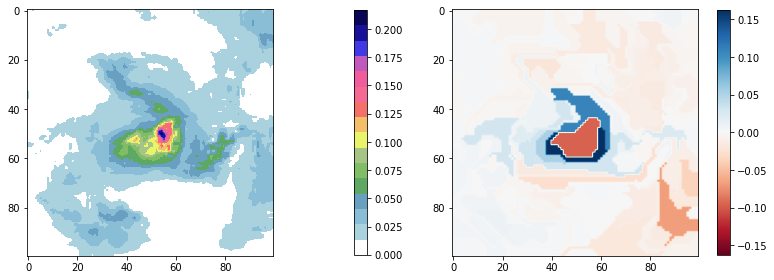

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
precip_cmap,precip_norm = make_cmap()
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 4))
m = ax1.imshow(tcs[storm,:,:], cmap = precip_cmap)
cbar_ax = fig.add_axes([0.5, 0.1, 0.015, 0.85])
plt.colorbar(m,cax=cbar_ax)
m = ax2.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
cbar_ax = fig.add_axes([0.92, 0.1, 0.015, 0.85])
plt.colorbar(m,cax=cbar_ax)
# plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, 
#                     top=0.9, wspace=6,hspace=0.4)
plt.subplots_adjust(wspace=1,hspace=0.4)
plt.tight_layout()


In [ ]:
def explain(explainer,storm):

    explanation = explainer.explain_instance(X_vec[storm], 
                                         classifier_fn = simple_rf_pipeline.predict_proba, 
                                         top_labels=6, hide_color=0, num_samples=30000, segmentation_fn=segmenter)
    
    # if increasing number of segments then increase number of samples

    #Select the same class explained on the figures above.
    ind =  explanation.top_labels[0]

    #Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

    #Plot. The visualization makes more sense if a symmetrical colorbar is used.
    precip_cmap,precip_norm = make_cmap()
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 4))
    m = ax1.imshow(tcs[storm,:,:], cmap = precip_cmap)
    ax1.set_title("Tropical cyclone rainfall")
    cbar_ax = fig.add_axes([0.42, 0.095, 0.015, 0.86])
    plt.colorbar(m,cax=cbar_ax)
    m = ax2.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    # m = ax2.contourf(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    ax2.set_title("Explanation weight")
    cbar_ax = fig.add_axes([0.88, 0.095, 0.015, 0.86])
    plt.colorbar(m,cax=cbar_ax)
    # plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, 
    #                     top=0.9, wspace=6,hspace=0.4)
    # plt.subplots_adjust(wspace=1,hspace=0.4)
    plt.tight_layout()
    

  0%|          | 0/30000 [00:00<?, ?it/s]

/user/work/al18709/.conda/envs/acidic/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


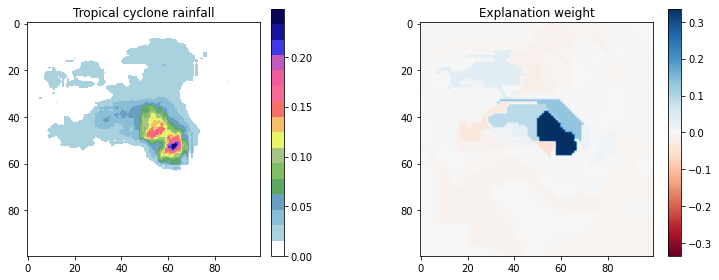

In [ ]:
explain(explainer,260)
# 280 is a good shape

  0%|          | 0/30000 [00:00<?, ?it/s]

/user/work/al18709/.conda/envs/acidic/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


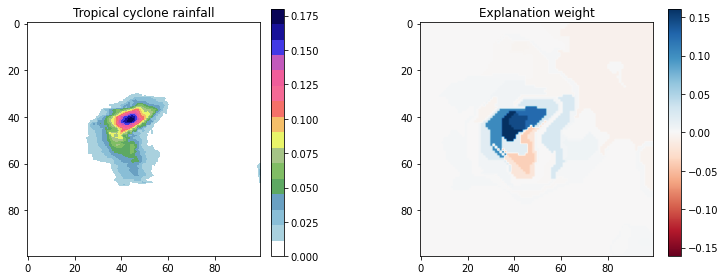

In [ ]:
explain(explainer,399)

  0%|          | 0/30000 [00:00<?, ?it/s]

/user/work/al18709/.conda/envs/acidic/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


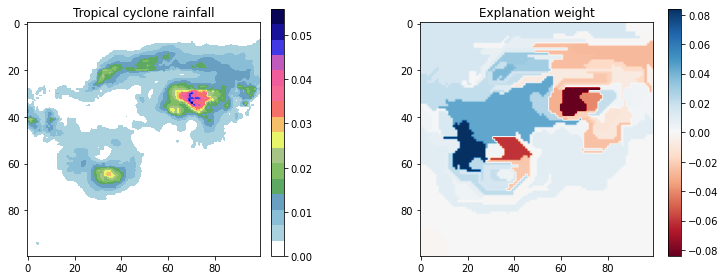

In [ ]:
explain(explainer,10)

  0%|          | 0/30000 [00:00<?, ?it/s]

/user/work/al18709/.conda/envs/acidic/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


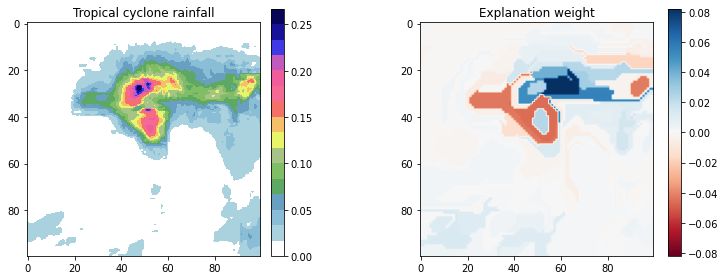

In [ ]:
explain(explainer,30)

  0%|          | 0/30000 [00:00<?, ?it/s]

/user/work/al18709/.conda/envs/acidic/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


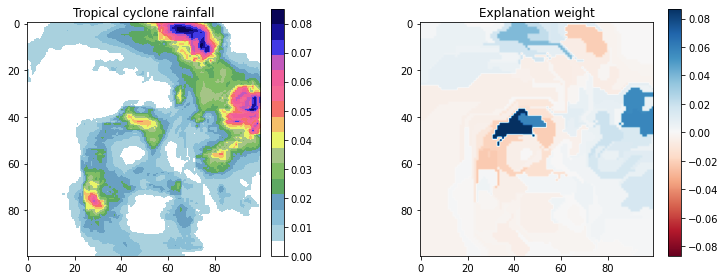

In [ ]:
explain(explainer,135)

  0%|          | 0/30000 [00:00<?, ?it/s]

/user/work/al18709/.conda/envs/acidic/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


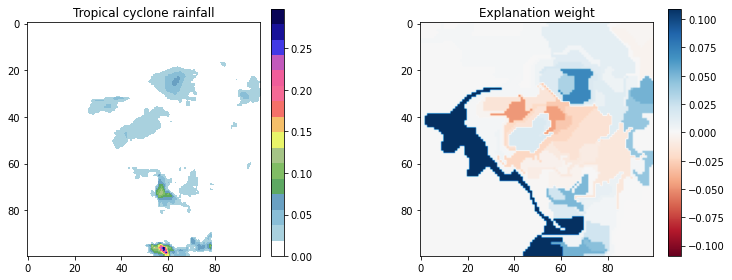

In [ ]:
explain(explainer,201)

  0%|          | 0/30000 [00:00<?, ?it/s]

/user/work/al18709/.conda/envs/acidic/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


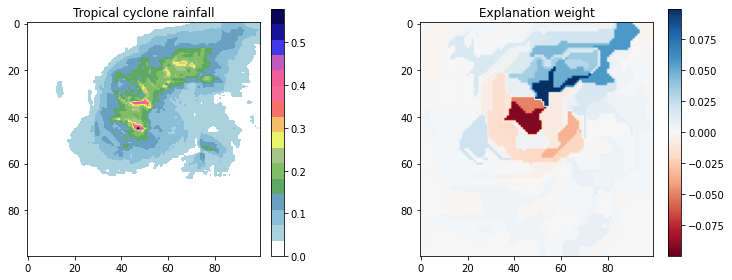

In [ ]:
explain(explainer,222)

  0%|          | 0/30000 [00:00<?, ?it/s]

/user/work/al18709/.conda/envs/acidic/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


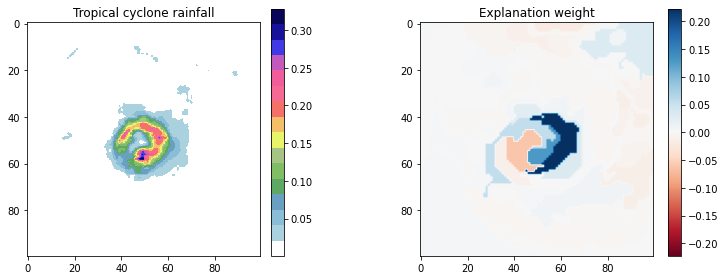

In [ ]:
explain(explainer,280)